### Prior specification: Define and justify appropriate priors for each of the parameters in the model

We will consider priors for $\beta_{0}$ and $\beta_{1}$, where $\beta_{0}$ represents the intercept of the model considered for the growth rate and $\beta_{1}$ the slope of the linear model. We will model the log of the growth rate, in order to avoid having negative growth rate values. An alternative for this model is to model the square root of the growth rate (with the power link function) instead of the exponential. This model would as well make sure that the growth rate will always take positive values. 

Because we don't have any prior knowledge of what suitable values for $\beta_{0}$ and $\beta_{1}$ should be considered, we will use uninformative priors. 
One solution is to consider priors modeled as a Uniform distribution, Uniform(0, $T$) with $T$ large, to account for a high range of possible values, equally probable. The problem with choosing a Uniform distribution on this range would be that this would consider values in interval (0, $T$) and this would be too restrictive for $\beta_{0}$ and $\beta_{1}$. To fix this we could consider a Uniform on ($-T$, $T$) that could sample negative values as well. An alternative is to consider a Normal distribution with a very low precision (or very high variance), such as $\mathcal{N}(0, \tau=0.001)$ where $\tau$ is the precision. Further alternatives for setting the priors would be to consider prior elicitation using an expert in the domain or to consider a hierarchical model where $T$ or $\tau$ (or $\sigma$) could be further modeled as random variables rather than fixed constants. For the purpose of this modelling we will use:

- $\beta_{0} \sim \mathcal{N}(0, \tau=0.001)$
- $\beta_{1} \sim \mathcal{N}(0, \tau=0.001)$

Additionally, we need to consider prior for $\sigma_{N}$. In this case we need to consider distributions only on the positive range (because standard deviation cannot take negative values), and to account for the lack of knowledge of what these parameters could be, we will use uninformative priors as well. A range of possible solutions are as follows: 

- Truncated Normal distribution - truncated to allow only positive values
- LogNormal distribution
- Gamma (a very uninformative Gamma could be $\sim Gamma(\alpha=0.00001, \beta=0.00001)$)
- Uniform (0, $T$) with T positive. 

All of the above would be uninformative and keep the standard deviation positive. 
We will choose Uniform priors for the standard deviation of the process and observations because in general the Uniform distribution is less informative than the other ones specified above.

- $\sigma_{N} \sim U(0, 1)$
In BUGS, we could even specify a flat prior using $x \sim dflat()$

In [ ]:
library(statsecol)
library(zoo)
library(jagsUI)
library(MCMCvis)
library(coda)
library(dplyr)
library(formattable)
library(ggplot2)
data("wildebeest")

In [2]:
non_na_indices = which(!is.na(wildebeest$Nhat))
wildebeest_backfilled <- na.locf(wildebeest, fromLast=T)

Before we apply the modelling in the BUGS language, we will validate below if the exponential model is suitable to model the growth rate as a function of rain. This comes with a caveat because we have missing data that was backfilled previously. Regardless of this, we will still run an analysis to check the dependence between rain and growth rate. 

First we need to find the growth rate from the dataset available. For this we will consider $r_{t} = \frac{Nhat_{t+1}}{Nhat_{t}}$ the growth rate between $Nhat_t$ and $Nhat_{t+1}$.

In [ ]:
# we set the growth and fill the last row with zero, since the growth rate is not known
# last row will not be considered for the model anyways
wildebeest$growth <- c(wildebeest$Nhat[-1]/wildebeest$Nhat[-nrow(wildebeest)], 0)

growth_rain <- data.frame(
    Growth = wildebeest$growth[-nrow(wildebeest)],
    Rain = wildebeest$rain[-nrow(wildebeest)]
)

In [ ]:
# Plot the growth rate vs rain. The goal is to inspect visually if there is any trend in the data
plot(growth_rain$Rain, growth_rain$Growth, xlab="Rain", ylab="Growth rate", main="Growth rate vs Rain")

|                                    |
|:----------------------------------:|
|![](assignment2_img/rain_growth.png)|

With a correlation of only 0.13, the initial exploratory analysis doesn't seem to suggest that growth is well explained by rain.

First we consider a model that is modelling the square root of growth rate as a function of rain.

In [ ]:
growth_rain$Sqrtgrowth <- sqrt(growth_rain$Growth)
linear_model <- lm(Sqrtgrowth ~ Rain, data=growth_rain)
linear_model_df = data.frame(round(anova(linear_model), 2))

|                               |
|:-----------------------------:|
|![](assignment2_img/anova1.png)|

Considering the square root of the growth as a function of rain doesn't seem to show a significant result (p-value 0.21). This means that the simple linear model, does not provide a good fit for the data. We will try an exponential model as initially intended.

In [ ]:
fit <- glm(formula = Growth ~ Rain,  family = Gamma(link="log"), data=growth_rain)
glm_df = data.frame(round(anova(fit, test="F"), 2))

|                               |
|:-----------------------------:|
|![](assignment2_img/anova2.png)|

Neither of these models seem to be significant, there could be two reasons why the growth might not be well explained by the rain. One is that the assumption that we can backfill data and consider a model with repeated yearly values is wrong. The second one is that in reality, it is very unlikely that the growth rate is just a function of rain. For the purpose of the practical, we will consider growth as a function of rain, as indicated in the project details.

### BUGS model description: Write the model above in the BUGS language

- $N_{t}|N_{t-1} \sim \mathcal{N}(r_{t}N_{t-1} - C_{t-1}, \sigma_{N}^{2})$
- $log(r_{t}) = \beta_{0} + \beta_{1}Rain_{t}$
- $y_{t}|N_{t} \sim \mathcal{N}(N_{t}, \sigma_{y}^{2})$

Growth rate $r_{t} = e^{\beta_{0} + \beta_{1}rain}$ modelled as an exponential function to avoid negative values. An alternative we could consider modelling the square root of growth rate, in that case $r_{t} = (\beta_{0} + \beta_{1}rain)^{2}$. To avoid having negative populations, because the Normal distribution has the support on $(-\infty, \infty)$ we will reject any negative values sampled. This allows us to work with the Normal distribution rather than apply extra transformations to the population in order to satisfy the constraints. An alternative would be to model the square root of the population or the logarithm and transform it back accordingly. In the BUGS language, we can do the following by ```dnorm(r[t] * N[t] - catch[t], tau.n)T(0,)``` where ```T(0,)``` specifies to reject any values less than 0.


In [ ]:
sink("project2.txt")
cat("
model{

  # Priors and constraints
  N1 ~ dunif(0, 2)
  N[1] <- N1

  b0 ~ dnorm(0, 0.01)  # Prior for the Intercept
  b1 ~ dnorm(0, 0.01)  # Prior for the slope

  sig.n ~ dunif(0, 1)     # Standard deviation for the population
  tau.n <- pow(sig.n, -2) # Precision for the state process

  # Likelihood - State process
  for(t in 1:(nyrs-1)) {
    log.r[t] <- b0 + b1*rain[t] # Linear model for the logarithm of the growth rate
    log(r[t]) <- log.r[t]       # Link function for the parameter

    # We use T(0, ) to make sure that the values sampled 
    # are positively truncated. This means that if a negative
    # value is sampled, a new value will be sampled until positive.
    # We want the population counts to be positive all the time
    # but the support of the normal distribution is (-inf, inf)
    # so we need this truncation to conform with the boundaries
    # of a real population.
    N[t+1] ~ dnorm(r[t] * N[t] - catch[t], tau.n) #T(0,)
  }

  # Likelihood - Observation process
  for (t in non_na_indices) {
     y[t] ~ dnorm(N[t], pow(sig.y[t], -2))

  }
}
", fill = TRUE)
sink()

### Model fitting and interpretation

In [ ]:
# Years we want to project forward
projection <- 5

# Passing in parameters from dataset
model_parameters <- list(
  # Vector of rain quantity observed each year
  # plus extra values for projection
  rain = c(wildebeest$rain, rep(mean(wildebeest$rain), projection)),
  # Catch - the amount harvested (or illegal poaching)
  # that happened on the wildebeest population including
  # values for the projection.
  catch = c(wildebeest$Catch,rep(0.04, projection)), 
  # Vector of population observations
  # We need to consider a logarithm transformation 
  # as the model is modelling the logarithm of the counts
  # in order to avoid negative values
  y = c(wildebeest$Nhat, rep(NA,projection)),
  # Number of years to include in the simulation
  # Each sample will contain nyrs of data
  nyrs = nrow(wildebeest) + projection,
  # Standard error given in the dataset
  sig.y = c(wildebeest$sehat, sample(wildebeest$sehat, projection)),
  # indices for which the Nhat column in the wildebeest dataset has value
  non_na_indices = non_na_indices
)
    
# Initial values
# For b0, b1 and sig.n, we will generate randomly
# values to make sure that multiple chains are not
# starting from the same initial configuration.
initial_values <- function() {
  list(
    N1 = runif(1, 0, 2),
    N = c(NA, tail(wildebeest_backfilled$Nhat, -1), rep(NA, projection)),
    sig.n = runif(1, 0, 1),
    b0 = runif(1, -2, 2),
    b1 = runif(1, -2, 2)
  )
}

# Parameters that we want to monitor from the model
# b0, b1, sig.n and N will be monitored to see if the
# chains converge to the posterior distribution. 
monitored_parameters <- c("b0", "b1", "sig.n", "N")

# Number of chains that we want to run
nc <- 3
# Number of iterations for burn-in. These
# iteration will be discarded before considering
# summaries or chain convergence diagnostics.
nb <- 100000
# Total number of iterations to run the chain.
# We started with smaller samples and increased
# the values until we got to some satisfactory
# effective sample sizes for the parameters of
# interest.
ni <- 100000 + nb

# Number of thinning samples. This is set to 10
# because a thinning of 1 shows a very high level
# of autocorrelation for all 4 parameters of interest.
# With a thinning of 10 we see very little autocorrelation.
nt <- 10

# Start the MCMC algorithm with the parameters provided
out <- jags(
    data = model_parameters,
    inits = initial_values,
    parameters.to.save = monitored_parameters,
    model.file = "project2.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)

# Draw trace plots and density plots for the monitored parameters
MCMCtrace(
    out,                                 # the fitted model
    params = monitored_parameters[1:3],  # out parameters of interest
    iter = ni,                           # plot all iterations
    pdf = FALSE,                         # don't write to a PDF
    ind = FALSE                          # chain specific densities
)

In [ ]:
MCMC_Param_Summary = MCMCsummary(out,
    params = monitored_parameters[1:3] #out parameters of interest
) 

### Prediction

Warning message:
“Removed 23 rows containing missing values (geom_point).”


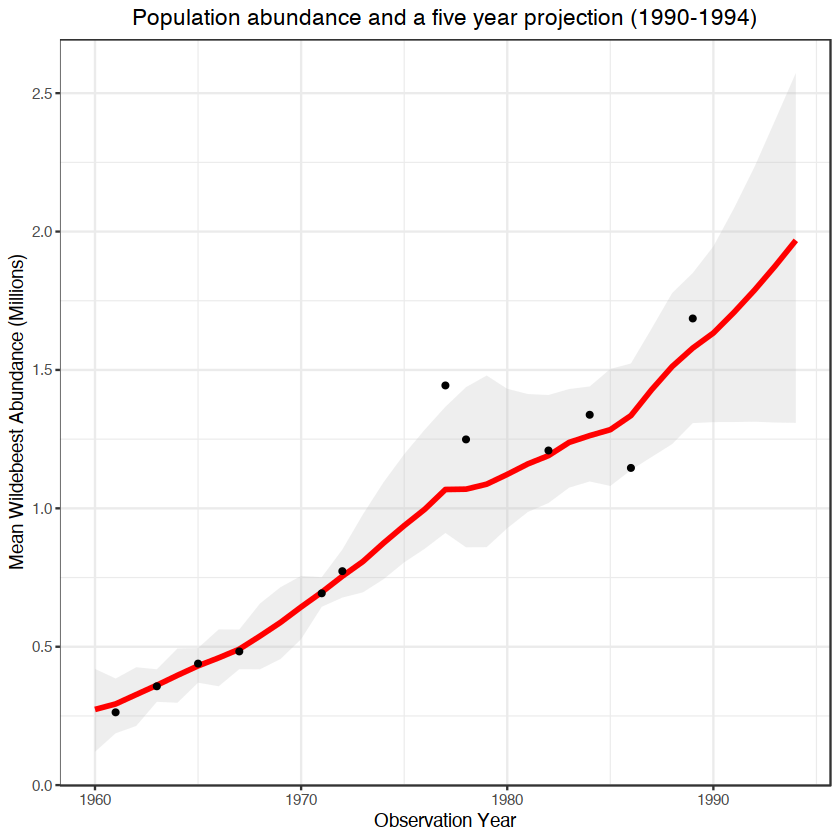

In [41]:
#Putting outputs into a data frame
projection_plot_df <- data.frame(
    Year = c(wildebeest$year,1990:1994),
    Mean = out$mean$N,
    Lower = out$q2.5$N,
    Upper = out$q97.5$N,
    Obs = c(wildebeest$Nhat,rep(NA,projection))
)

ggplot(data = projection_plot_df) + 
  geom_ribbon(aes(x=Year, y=Mean, ymin=Lower, ymax=Upper),
              fill="grey", alpha = 0.25) +
  geom_line(aes(x=Year, y=Mean), size=1.2, color="red") + 
  geom_point(aes(x=Year, y=Obs), size=1.2) +
  theme_bw()+
  labs(title = 'Population abundance and a five year projection (1990-1994)',
       y = 'Mean Wildebeest Abundance (Millions)',
       x = 'Observation Year')+
  theme(plot.title = element_text(hjust = 0.5))

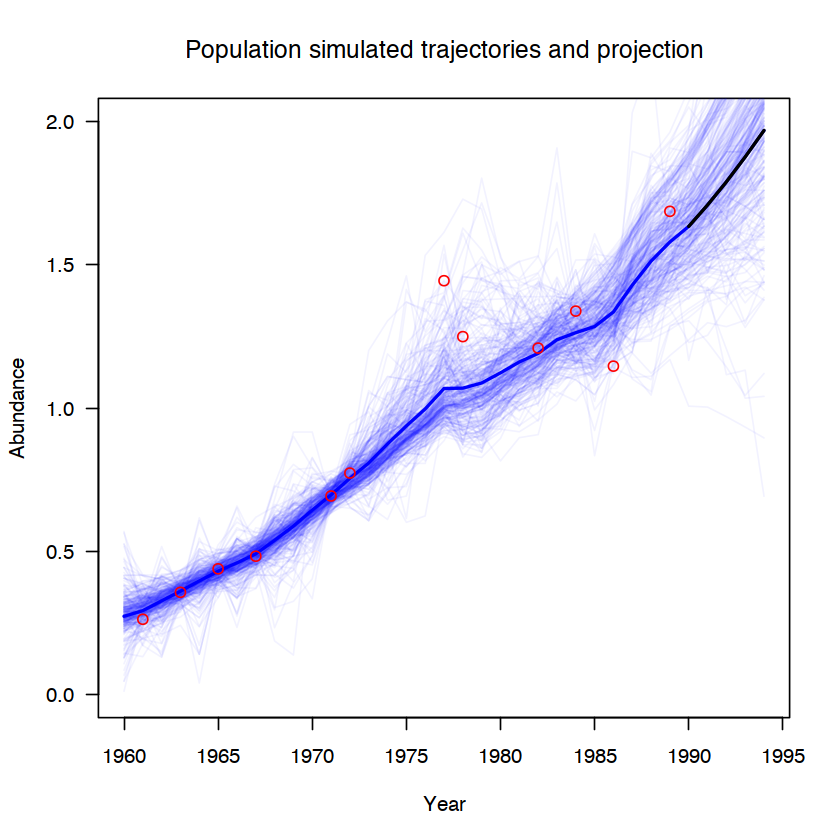

In [126]:
Years = c(wildebeest$year,1990:1994)
plot(Years, c(wildebeest_backfilled$Nhat, rep(NA, 5)), ylim=c(0,2), xlim=c(1960, 1994), las=1,
ylab="Abundance", xlab="Year",pch="", main="Population simulated trajectories and projection")
matlines(x=Years, y=t(out$sims.list$N[sample(1:5000,300,replace = TRUE),]),
lty=1,col=adjustcolor("blue",0.05))
lines(Years, apply(out$sims.list$N,2,mean), col="blue",lwd=2)
lines(1990:1994, apply(out$sims.list$N,2,mean)[31:35], col="black", lwd=2)
points(Years, c(wildebeest$Nhat, rep(NA, 5)), lwd=1, col="red")

In [27]:
#Putting outputs into a data frame
projection_plot_df <- data.frame(
    Year = c(wildebeest$year,1990:1994),
    Mean = out$mean$N,
    Lower = out$q2.5$N,
    Upper = out$q97.5$N,
    Obs = c(wildebeest$Nhat,rep(NA,projection))
)

In [ ]:
#Formatting the table for Our Estimates
estimates_data_frame = data.frame(
    Year = c(wildebeest$year,1990:1994),
    Lower = round(out$q2.5$N,2),
    `Mean_Abundance` = round(out$mean$N,2),
    Upper = round(out$q97.5$N,2),
    stringsAsFactors = FALSE
)

#Setting Some Colors to Call for the table
customGreen0 = "#DeF7E9"
customGreen = "#71CA97"
customRed = "#ff7f7f"
light_blue = '#ADD8E6'
light_green = '#DAF7A6'
light_yellow = '#FFFFE0'

formatted_CI = formattable(
    estimates_data_frame[31:35,],
    caption = "Credible Interval Table",
    align =c("l","c","c","c","c"),
    list(Year = formatter(
        "span", style = ~ style(color = "black",font.weight = "bold")),
        Mean_Abundance = color_tile(light_green, light_green),
        `Lower`= color_tile(light_blue, light_blue),
        `Upper`= color_tile(light_yellow, light_yellow)
    )
)

|                                          |
|:----------------------------------------:|
|![](assignment2_img/credible_interval.png)|

In [ ]:
MCMC_Param_Summary = data.frame(round(MCMC_Param_Summary,2))
colnames(MCMC_Param_Summary) = c("Mean", "SD", "2.5%", "50%", "97.5%", "Rhat", "n.eff")

### Posterior inference

Given that we ran the Monte Carlo simulation, we're interested in finding out if the model has converged to the stationary distribution, and we can use the posterior estimates of the parameters of interest with confidence. While nothing can guarantee that the model has converged, visual tools such as traceplots or autocorrelation plots can give a certain confidence that the model is doing the right thing.

The first thing we look at are traceplots for the parameters of interest, in this case $b_{0}$, $b_{1}$ and $sig.n$ for which we have set prior distributions. The analysis is set up to run 3 chains in parallel, each color on the traceplot corresponding to a chain. Usually, if the traceplots look like "fat hairy catterpillars" (and not like a snake) we have evidence that the chains are doing well. We're looking for evidence that the chains are mixing well together and there is no evidence of a pattern. The traceplots below suggest that we have achieved this, seeing positive results from this analysis. It's worth mentinoning that on a few iterations we have noticed that the chains might be stuck in particular parts of the distribution or show bimodal posterior distributions. In these situations we tweaked the starting points. Another alternative to make the chains converge faster is to normalize the covariates in the linear model by substracting the empirical mean. In this case, we would reduce the correlation between $b_{1}$ and $b_{0}$ because the intercept would now relocate to the "centre" of the data. As we said, all 3 traceplots look like a "fat hairy caterpillar" so we can continue our diagnosis.

|                           |                           |
|:-------------------------:|:-------------------------:|
|![](assignment2_img/b0.png)|![](assignment2_img/b1.png)|

|                           |
|:-------------------------:|
|![](assignment2_img/sn.png)|

Density plots can guide in understanding if multiple chains are agreeing with each other. We're looking into a unimodal, bell shaped distribution. In case the distribution is not unimodal, it could mean that either the chains didn't converge to the stationary distribution or in reality there are multiple modes. The density plots for $b_{0}$, $b_{1}$ and $sig.n$ seem to be looking relatively well.

|                            |                            |
|:--------------------------:|:--------------------------:|
|![](assignment2_img/db0.png)|![](assignment2_img/db1.png)|

|                            |
|:--------------------------:|
|![](assignment2_img/dsn.png)|

In adition to the trace and density plots, we can also consider checking the autocorrelation plots to analyse if we have dependence between samples. With a high autocorrelation, our posterior distributions would not be reliable because we don't have enough independent samples and each sample would contain less information. For $b_{0}$ and $b_{1}$ we can be confident that our effective sample size is large enough to be able to draw conclusions from the posterior distribution. The initial analysis done before, showed a very high autocorrelation for all the parameters of interest but increasing the thinning from 1 to 10 decreased the autocorelation considerably. Further improvements can be done by increasing the number of iterations the chain is performing.

|b0                             |b1                             |
|:-----------------------------:|:-----------------------------:|
|![](assignment2_img/acf_b0.png)|![](assignment2_img/acf_b1.png)|

|sig.n                            |
|:-------------------------------:|
|![](assignment2_img/acf_sigy.png)|

In [ ]:
MCMCsummary(out,
            params = monitored_parameters[1:4]) #out parameters of interest

An additional check that we can do to assess convergence for the MCMC is to check the Brooks-Gelman-Rubin (BGR) $Rhat$ which is checking the ratio between-chains and within-chains variation. If this is close to 1, we can say with confidence that the chains have converged to a stationary distribution. If this wouldn't be the case, the variation between chains would be much higher and the ration would be further away from 1. The value for the BGR diagnostic is in the table below, and we can see that $Rhat$ is equal to 1. Further evidence that the chains converged to stationary distribution. The number of effective samples also seems considerably high and we can expect a relatively low MC error.   

In [ ]:
formatted_params = formattable(
    MCMC_Param_Summary,
    caption = "Parameter Summaries",
    align =c("c","c","c","c","c","c","c"),
    list(mean = formatter(
        "span", style = ~ style(color = "black",font.weight = "bold")),
        Mean = color_tile(light_green, light_green),
        SD = color_tile(light_green, light_green),
        `2.5%`= color_tile(light_blue, light_blue),
        `50%`= color_tile(light_yellow, light_yellow),
        `97.5%` = color_tile(light_green, light_green),
        `Rhat`= color_tile(light_blue, light_blue),
        `n.eff`= color_tile(light_yellow, light_yellow)
    )
)

|                                          |
|:----------------------------------------:|
|![](assignment2_img/parameter_summary.png)|

As a summary we can expect the population to grow to close to 2 million by 1996 if the harvest and the other external factors remain the same.

#### Work breakdown

We met together and coded up the model (pair programming) and then we separated the sections accordingly. One of us worked on the prior and linear regression while the other focused on parameter interpretation and posterior inference. At the end we split the work for charts and graphical representation of the outcomes. 